# Becquerel Overview

This notebook demonstrates some of the main features and functionalities of `becquerel`:

1. [`bq.Spectrum`](#1.-bq.Spectrum)
  - [Constructor](#1.1-From-scratch)
  - [Energy Calibration Models](#1.2-Energy-Calibration-Models)
  - [File IO](#1.3-From-File)
  - [Backrgound Subtraction](#1.4-Background-Subtraction)
  - [Rebinning](#1.5-Rebinning)
  - [Scaling](#1.6-Scaling)
  - [Peak Finding + Auto Calibration](#1.7-Automatic-Calibration)
1. [Nuclear-Data](#2.-Nuclear-Data)
  - [`bq.Element`](#2.1-bq.Element)
  - [`bq.Isotope`](#2.2-bq.Isotope)
  - [`bq.IsotopeQuantity`](#2.3-bq.IsotopeQuantity)
  - [`bq.materials`](#2.4-bq.materials)
  - [`bq.nndc`](#2.5-bq.nndc)
  - [`bq.xcom`](#2.6-bq.xcom)

For more details on particular features please see the other notebooks in this directory as noted. In addition, a few practical examples of using `becquerel` are given in the [misc notebook](./misc.ipynb)

In [1]:
%pylab inline
import pandas as pd
import becquerel as bq
from pprint import pprint
np.random.seed(0)

Populating the interactive namespace from numpy and matplotlib


# 1. `bq.Spectrum`

The core class in `bq` is `Spectrum`. This class contains a variety of tools for handling **single spectrum** data.

Further details can be found in the [spectrum notebook](./spectrum.ipynb) and [spectrum plotting notebook](./plotting.ipynb).

In [2]:
bq.Spectrum?

## 1.1 From scratch

In [3]:
c, _ = np.histogram(np.random.poisson(50, 1000), bins=np.arange(101))
spec = bq.Spectrum(counts=c, livetime=60.)
spec

becquerel.Spectrum
    start_time:     None
    stop_time:      None
    realtime:       None
    livetime:       60.0
    is_calibrated:  False
    num_bins:       100
    gross_counts:   1000+/-33
    gross_cps:      16.7+/-0.5
    filename:       None

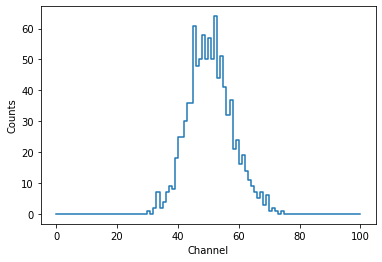

In [4]:
spec.plot(xmode='channels');

In [5]:
try:
    spec.plot(xmode='energy')
except bq.PlottingError as e:
    print('ERROR:', e)
    plt.close('all')

ERROR: Spectrum is not calibrated, however x axis was requested as energy


## 1.2 Energy Calibration Models

Base class for energy calibration models: `EnergyCalBase`. Currently implemented:

- `LinearEnergyCal`

Further details can be found in the [energycal notebook](./energycal.ipynb).

becquerel.Spectrum
    start_time:     None
    stop_time:      None
    realtime:       None
    livetime:       60.0
    is_calibrated:  True
    num_bins:       100
    gross_counts:   1000+/-33
    gross_cps:      16.7+/-0.5
    filename:       None


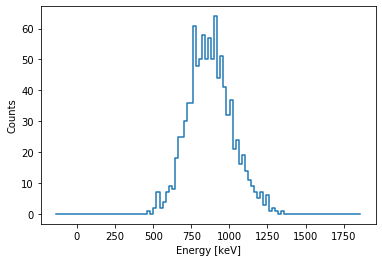

In [6]:
chlist = (40, 80)
kevlist = (661.7, 1460.83)
cal = bq.LinearEnergyCal.from_points(chlist=chlist, kevlist=kevlist)
cal.update_fit()
spec.apply_calibration(cal)
print(spec)
spec.plot(xmode='keV');

In [7]:
# New spec
c, _ = np.histogram(np.random.poisson(50, 1000), bins=np.arange(101))
spec2 = bq.Spectrum(counts=c, livetime=60.)
spec2

becquerel.Spectrum
    start_time:     None
    stop_time:      None
    realtime:       None
    livetime:       60.0
    is_calibrated:  False
    num_bins:       100
    gross_counts:   1000+/-32
    gross_cps:      16.7+/-0.5
    filename:       None

In [8]:
spec2.calibrate_like(spec)
spec2

becquerel.Spectrum
    start_time:     None
    stop_time:      None
    realtime:       None
    livetime:       60.0
    is_calibrated:  True
    num_bins:       100
    gross_counts:   1000+/-32
    gross_cps:      16.7+/-0.5
    filename:       None

## 1.3 From File

`becquerel` currently provides parsers for:

- `SPE`
- `SPC`
- `CNF`

In [9]:
spec = bq.Spectrum.from_file('../tests/samples/1110C NAA cave pottery.Spe')
spec

SpeFile: Reading file ../tests/samples/1110C NAA cave pottery.Spe


becquerel.Spectrum
    start_time:     2017-04-25 12:54:27
    stop_time:      2017-04-25 17:30:24
    realtime:       16557.0
    livetime:       16543.0
    is_calibrated:  True
    num_bins:       16384
    gross_counts:   (3.047+/-0.006)e+05
    gross_cps:      18.419+/-0.034
    filename:       ../tests/samples/1110C NAA cave pottery.Spe

In [10]:
spec.is_calibrated

True

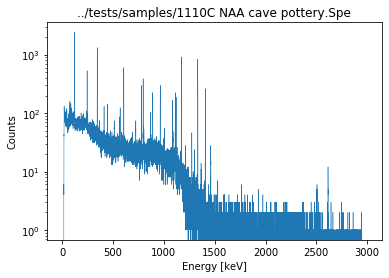

In [11]:
spec.plot(yscale='log', linewidth=0.5, ymode='counts');

In [12]:
%%capture
spec = bq.Spectrum.from_file('../tests/samples/01122014152731-GT01122014182338-GA37.4963000N-GO122.4633000W.cnf')

In [13]:
spec

becquerel.Spectrum
    start_time:     2014-01-12 15:12:28.125000
    stop_time:      2014-01-12 15:26:37.635000
    realtime:       849.5099998999999
    livetime:       841.4199999
    is_calibrated:  True
    num_bins:       4096
    gross_counts:   (6.837+/-0.008)e+05
    gross_cps:      812.5+/-1.0
    filename:       ../tests/samples/01122014152731-GT01122014182338-GA37.4963000N-GO122.4633000W.cnf

In [14]:
%%capture
spec = bq.Spectrum.from_file('../tests/samples/Alcatraz14.Spc')

In [15]:
spec

becquerel.Spectrum
    start_time:     2012-09-17 13:41:07
    stop_time:      2012-09-17 13:41:07
    realtime:       905.0
    livetime:       900.0
    is_calibrated:  True
    num_bins:       8192
    gross_counts:   (1.330+/-0.004)e+05
    gross_cps:      147.8+/-0.4
    filename:       ../tests/samples/Alcatraz14.Spc

## 1.4 Background Subtraction

In [16]:
spec = bq.Spectrum.from_file('../tests/samples/1110C NAA cave pottery.Spe')
print(spec)
bkg = bq.Spectrum.from_file('../tests/samples/1110C NAA cave background May 2017.spe')
print(bkg)

SpeFile: Reading file ../tests/samples/1110C NAA cave pottery.Spe
becquerel.Spectrum
    start_time:     2017-04-25 12:54:27
    stop_time:      2017-04-25 17:30:24
    realtime:       16557.0
    livetime:       16543.0
    is_calibrated:  True
    num_bins:       16384
    gross_counts:   (3.047+/-0.006)e+05
    gross_cps:      18.419+/-0.034
    filename:       ../tests/samples/1110C NAA cave pottery.Spe
SpeFile: Reading file ../tests/samples/1110C NAA cave background May 2017.spe
becquerel.Spectrum
    start_time:     2017-04-26 11:05:11
    stop_time:      2017-05-01 12:43:34
    realtime:       437903.0
    livetime:       437817.0
    is_calibrated:  True
    num_bins:       16384
    gross_counts:   (1.0529+/-0.0010)e+06
    gross_cps:      2.4049+/-0.0023
    filename:       ../tests/samples/1110C NAA cave background May 2017.spe


In [17]:
bkgsub = spec - bkg
print('Total pottery countrate:    {:6.3f}'.format(np.sum(spec.cps)))
print('Total background countrate: {:6.3f}'.format(np.sum(bkg.cps)))
print('Total subtracted countrate: {:6.3f}'.format(np.sum(bkgsub.cps)))

becquerel/core/spectrum.py:714: SpectrumWarning: Subtraction of counts-based specta, spectra have been converted to CPS
  'have been converted to CPS', SpectrumWarning)


Total pottery countrate:    18.419+/- 0.034
Total background countrate:  2.405+/- 0.002
Total subtracted countrate: 16.014+/- 0.034


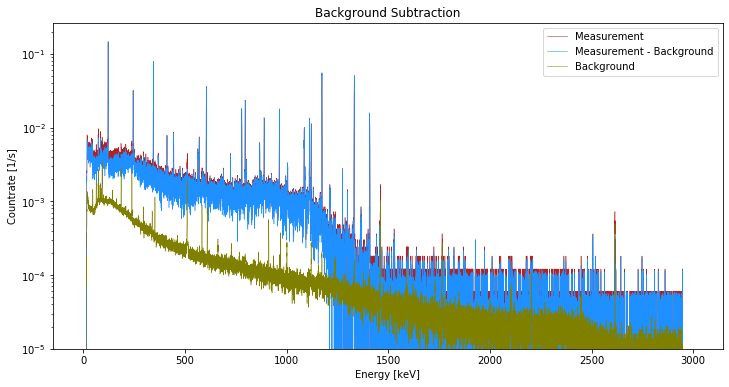

In [18]:
fig, ax = plt.subplots(1, figsize=(12, 6))
ax = spec.plot(color='firebrick', linewidth=0.5, yscale='log', ax=ax, label='Measurement', ymode='cps')
bkgsub.plot(ax=ax, color='dodgerblue', linewidth=0.5, label='Measurement - Background', ymode='cps')
bkg.plot(ax=ax, color='olive', linewidth=0.5, label='Background', ymode='cps')
ax.set_ylim(bottom=1e-5)
ax.set_title('Background Subtraction')
ax.legend();

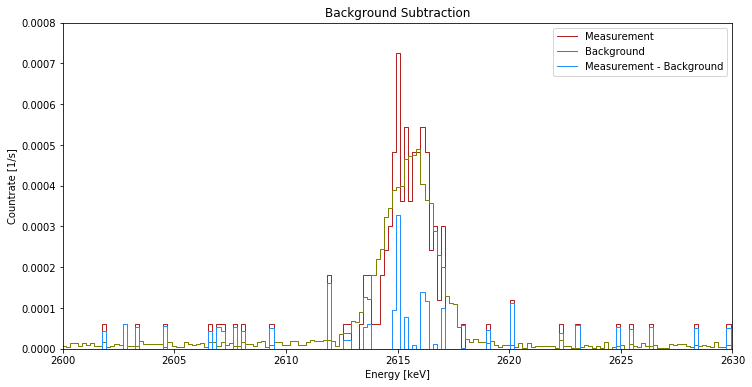

In [19]:
# Is there any Tl-208 in the background-subtracted spectrum?
fig, ax = plt.subplots(1, figsize=(12, 6))
ax = spec.plot(color='firebrick', linewidth=1, yscale='linear', ax=ax, label='Measurement', ymode='cps')
bkg.plot(ax=ax, color='olive', linewidth=1, label='Background', ymode='cps')
bkgsub.plot(ax=ax, color='dodgerblue', linewidth=1, label='Measurement - Background', ymode='cps')
ax.set_ylim(bottom=1e-5)
ax.set_title('Background Subtraction')
ax.legend()
plt.xlim(2600, 2630)
plt.ylim(0, 0.0008);

## 1.5 Rebinning

- deterministic (interpolation): `interpolation`
- stochastic (convert to listmode): `listmode`

Further details can be found in the [rebinning notebook](./rebinning.ipynb).

In [20]:
spec = bq.Spectrum.from_file('../tests/samples/1110C NAA cave pottery.Spe')
bkg = bq.Spectrum.from_file('../tests/samples/1110C NAA cave background May 2017.spe')
bkg_rebin = bkg.rebin(np.linspace(0., 3000., 16000))

SpeFile: Reading file ../tests/samples/1110C NAA cave pottery.Spe
SpeFile: Reading file ../tests/samples/1110C NAA cave background May 2017.spe


becquerel/core/rebin.py:82: RebinWarning: The last input edge is smaller than the last output edge, zeros will padded on the right side of the new spectrum
  RebinWarning)


In [21]:
try:
    bkgsub = spec - bkg_rebin
except bq.SpectrumError as e:
    print('ERROR:', e)

ERROR: Cannot add/subtract spectra of different lengths


In [22]:
spec_rebin = spec.rebin_like(bkg_rebin)

In [23]:
spec_rebin - bkg_rebin

becquerel.Spectrum
    start_time:     None
    stop_time:      None
    realtime:       None
    livetime:       None
    is_calibrated:  True
    num_bins:       15999
    gross_counts:   None
    gross_cps:      16.014+/-0.033
    filename:       None

## 1.6 Scaling

Multiplication or division will be applied to the data of the spectrum. The following decimates a spectrum by dividing by 10:

In [24]:
spec = bq.Spectrum.from_file('../tests/samples/1110C NAA cave background May 2017.spe')
spec_div  = spec / 10
print(spec_div)

SpeFile: Reading file ../tests/samples/1110C NAA cave background May 2017.spe
becquerel.Spectrum
    start_time:     None
    stop_time:      None
    realtime:       None
    livetime:       None
    is_calibrated:  True
    num_bins:       16384
    gross_counts:   (1.0529+/-0.0010)e+05
    gross_cps:      None
    filename:       None


One might however want to decimate a spectrum in a way consistent with Poisson statistics. For that there is the `downsample` method:

becquerel.Spectrum
    start_time:     None
    stop_time:      None
    realtime:       None
    livetime:       43781.7
    is_calibrated:  True
    num_bins:       16384
    gross_counts:   (1.0484+/-0.0033)e+05
    gross_cps:      2.395+/-0.008
    filename:       None


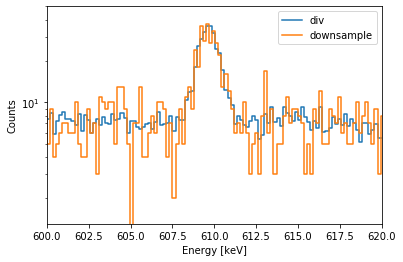

In [25]:
spec_downsample = spec.downsample(10, handle_livetime='reduce')
print(spec_downsample)

ax = spec_div.plot(label='div', ymode='counts', yscale='log')
spec_downsample.plot(ax=ax, label='downsample', ymode='counts')
ax.legend()
ax.set_xlim(600, 620)
ax.set_ylim(1.3, 5e1);

## 1.7 Automatic Calibration

There are utilities in Becquerel for automatically finding peaks in a raw spectrum and matching them to a list of energies as a first pass at a full calibration.

Further details can be found in the [autocal notebook](./autocal.ipynb).

Let's load an uncalibrated sodium iodide spectrum that has Cobalt-60 and background lines:

SpeFile: Reading file ../tests/samples/digibase_5min_30_1.spe


becquerel/parsers/spectrum_file.py:135: SpectrumFileParsingWarning: Spectrum will be initated without an energy calibration;invalid calibration, energies not monotonically increasing.
  SpectrumFileParsingWarning)


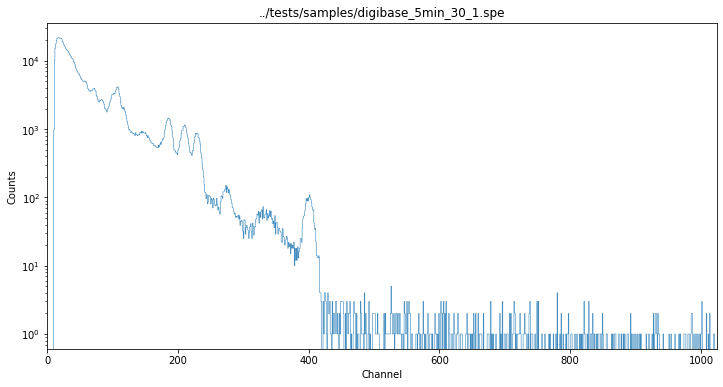

In [26]:
spec = bq.Spectrum.from_file('../tests/samples/digibase_5min_30_1.spe')
fig, ax = plt.subplots(1, figsize=(12, 6))
spec.plot(ax=ax, linewidth=0.5, xmode='channels', yscale='log')
plt.xlim(0, len(spec));

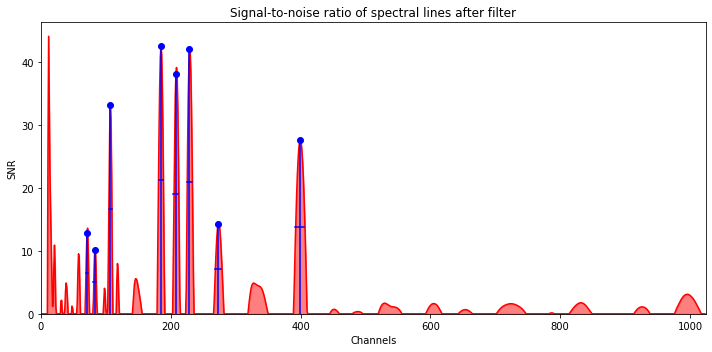

In [28]:
# filter the spectrum
kernel = bq.GaussianPeakFilter(400, 20, 3)
finder = bq.PeakFinder(spec, kernel)
finder.find_peaks(min_snr=10, xmin=50)
cal = bq.AutoCalibrator(finder)

plt.figure(figsize=(10, 5))
plt.title('Signal-to-noise ratio of spectral lines after filter')
cal.peakfinder.plot()
plt.tight_layout()

found best gain: 6.414880 keV/channel


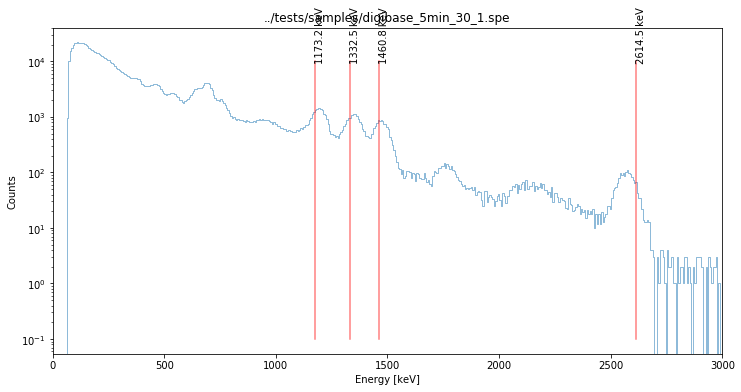

In [29]:
# perform calibration
cal.fit(
    [1173.2, 1332.5, 1460.8, 2614.5],
    gain_range=[5., 7.],
    de_max=100.,
)
spec.apply_calibration(cal.cal)

fig, ax = plt.subplots(1, figsize=(12, 6))
spec.plot(ax=ax, linewidth=0.5, xmode='energy', yscale='log')
for erg in cal.fit_energies:
    plt.plot([erg, erg], [1e-1, 1e4], 'r-', alpha=0.5)
    plt.text(erg, 1e4, '{:.1f} keV'.format(erg), rotation=90)
plt.xlim(0, 3000);

# 2. Nuclear Data

## 2.1 `bq.Element`

In [30]:
e1 = bq.Element('Cs')
e2 = bq.Element(55)
e3 = bq.Element('55')
print(e1, e2, e3)
print(e1 == e2 == e3)
print('{:%n(%s) Z=%z}'.format(e1))
pprint(e1.__dict__, width=10)

Cesium(Cs) Z=55 Cesium(Cs) Z=55 Cesium(Cs) Z=55
True
Cesium(Cs) Z=55
{'Z': 55,
 'atomic_mass': 132.91,
 'name': 'Cesium',
 'symbol': 'Cs'}


## 2.2 `bq.Isotope`

Further examples of `Isotope` and `IsotopeQuantity` can be found in the [isotopes notebook](./isotopes.ipynb).

In [31]:
i1 = bq.Isotope('Cs-137')
i2 = bq.Isotope('137CS')
i3 = bq.Isotope('Cs', 137)
i4 = bq.Isotope('Cesium-137')
i5 = bq.Isotope('137CAESIUM')
print(i1, i2, i3, i4, i5)
print(i1 == i2 == i3 == i4 == i5)

Cs-137 Cs-137 Cs-137 Cs-137 Cs-137
True


Isotope names and properties

In [32]:
iso = bq.Isotope('Tc-99m')
print(iso)
print('{:%n(%s)-%a%m Z=%z}'.format(iso))
pprint(iso.__dict__)
print('half-life: {:.2f} hr'.format(iso.half_life / 3600))

Tc-99m
Technetium(Tc)-99m Z=43
{'A': 99,
 'M': 1,
 'N': 56,
 'Z': 43,
 'atomic_mass': 98,
 'm': 'm',
 'name': 'Technetium',
 'symbol': 'Tc'}
half-life: 6.01 hr


More isotope properties such as half-life, stability, and natural abundance are available:

In [33]:
for a in range(39, 42):
    iso = bq.Isotope('Potassium', a)
    print('')
    print('Isotope: {}'.format(iso))
    print('    Spin-parity: {}'.format(iso.j_pi))
    if iso.abundance is not None:
        print('    Abundance:   {:.2f}%'.format(iso.abundance))
    print('    Stable?      {}'.format(iso.is_stable))
    if not iso.is_stable:
        print('    Half-life:   {:.3e} years'.format(iso.half_life / 365.25 / 24 / 3600))
        print('    Decay modes: {}'.format(iso.decay_modes))


Isotope: K-39
    Spin-parity: 3/2+
    Abundance:   93.26+/-0.00%
    Stable?      True

Isotope: K-40
    Spin-parity: 4-
    Abundance:   0.01+/-0.00%
    Stable?      False
    Half-life:   1.248e+09 years
    Decay modes: (['B-', 'EC'], [89.28, 10.72])

Isotope: K-41
    Spin-parity: 3/2+
    Abundance:   6.73+/-0.00%
    Stable?      True


## 2.3 `bq.IsotopeQuantity`

Source activity on a given date

Here's a check source activity on today's date:

In [34]:
ba133_chk = bq.IsotopeQuantity('ba133', date='2013-05-01', uci=10.02)
ba133_chk.uci_now()

6.520777229829132

Or for another date:

In [35]:
ba133_chk.uci_at('2018-02-16')

7.311855859452171

## 2.4 `bq.materials`

Access the [NIST X-ray mass attenuation coefficients database](https://www.nist.gov/pml/x-ray-mass-attenuation-coefficients) for [elements](https://physics.nist.gov/PhysRefData/XrayMassCoef/tab1.html) and [compounds](https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html).

In [36]:
elem_dat = bq.materials.fetch_element_data()
elem_dat.head()

,Z,Symbol,Element,Z_over_A,I_eV,Density
0,1,H,Hydrogen,0.99212,19.2,0.000084
1,2,He,Helium,0.49968,41.8,0.000166
2,3,Li,Lithium,0.43221,40.0,0.534000
3,4,Be,Beryllium,0.44384,63.7,1.848000
4,5,B,Boron,0.46245,76.0,2.370000


In [37]:
comp_dat = bq.materials.fetch_compound_data()
comp_dat.head()

,Material,Z_over_A,I_eV,Density,Composition_Z,Composition_symbol
0,A-150 Tissue-Equivalent Plastic,0.54903,65.1,1.127000,"[1: 0.101330, 6: 0.775498, 7: 0.035057, 8: 0.0...","[H 0.101330, C 0.775498, N 0.035057, O 0.05231..."
1,Adipose Tissue (ICRU-44),0.55579,64.8,0.950000,"[1: 0.114000, 6: 0.598000, 7: 0.007000, 8: 0.2...","[H 0.114000, C 0.598000, N 0.007000, O 0.27800..."
2,"Air, Dry (near sea level)",0.49919,85.7,0.001205,"[6: 0.000124, 7: 0.755268, 8: 0.231781, 18: 0....","[C 0.000124, N 0.755268, O 0.231781, Ar 0.012827]"
3,Alanine,0.53876,71.9,1.424000,"[1: 0.079192, 6: 0.404437, 7: 0.157213, 8: 0.3...","[H 0.079192, C 0.404437, N 0.157213, O 0.359157]"
4,B-100 Bone-Equivalent Plastic,0.52740,85.9,1.450000,"[1: 0.065473, 6: 0.536942, 7: 0.021500, 8: 0.0...","[H 0.065473, C 0.536942, N 0.021500, O 0.03208..."


## 2.5 `bq.nndc`

Tools to query the [National Nuclear Data Center databases](https://www.nndc.bnl.gov/nudat2/) to obtain decay radiation, branching ratios, and many other types of nuclear data.

Further details and examples can be found in the [nndc notebook](./nndc.ipynb) and the [nndc_chart_of_nuclides notebook](./nndc_chart_of_nuclides.ipynb).

Here are the gamma-ray lines above 5% branching ratio from Co-60:

In [38]:
rad = bq.nndc.fetch_decay_radiation(nuc='Co-60', type='Gamma', i_range=(5, None))
cols = ['Z', 'Element', 'A', 'Decay Mode', 'Radiation', 'Radiation Energy (keV)',
        'Radiation Intensity (%)', 'Energy Level (MeV)']
display(rad[cols])

,Z,Element,A,Decay Mode,Radiation,Radiation Energy (keV),Radiation Intensity (%),Energy Level (MeV)
0,27,CO,60,IT,G,6.915,9.1+/-0.4,0.058603+/-0.000007
1,27,CO,60,IT,G,6.93,18.0+/-0.8,0.058603+/-0.000007
2,27,CO,60,B-,G,1173.2280+/-0.0030,99.850+/-0.030,0
3,27,CO,60,B-,G,1332.492+/-0.004,99.9826+/-0.0006,0


In [39]:
# NNDC nuclear wallet cards are used by bq.Isotope but can be accessed directly like this:
data = bq.nndc.fetch_wallet_card(
    z_range=(19, 19),
    a_range=(37, 44),
    elevel_range=(0, 0),  # ground states only
)
display(data)

,Z,Element,A,m,M,N,JPi,Energy Level (MeV),Decay Mode,Branching (%),Mass Excess (MeV),T1/2 (txt),T1/2 (s),Abundance (%)
0,19,K,37,,0,18,3/2+,0.0,EC,100.00,-24.80020+/-0.00009,1.226 S 0.007,1.226000e+00,None
1,19,K,38,,0,19,3+,0.0,EC,100.00,-28.80075+/-0.00020,7.636 M 0.018,4.581600e+02,None
2,19,K,39,,0,20,3/2+,0.0,,NaN,-33.807190+/-0.000005,STABLE,inf,93.258+/-0.004
3,19,K,40,,0,21,4-,0.0,B-,89.28,-33.53549+/-0.00006,1.248E+9 Y 0.003E+9,3.938000e+16,0.01170+/-0.00010
4,19,K,40,,0,21,4-,0.0,EC,10.72,-33.53549+/-0.00006,1.248E+9 Y 0.003E+9,3.938000e+16,0.01170+/-0.00010
5,19,K,41,,0,22,3/2+,0.0,,NaN,-35.559543+/-0.000004,STABLE,inf,6.730+/-0.004
6,19,K,42,,0,23,2-,0.0,B-,100.00,-35.02203+/-0.00011,12.355 H 0.007,4.447800e+04,None
7,19,K,43,,0,24,3/2+,0.0,B-,100.00,-36.5754+/-0.0004,22.3 H 0.1,8.028000e+04,None
8,19,K,44,,0,25,2-,0.0,B-,100.00,-35.7815+/-0.0004,22.13 M 0.19,1.327800e+03,None


## 2.6 `bq.xcom`

The [NIST XCOM photon cross sections database](https://www.nist.gov/pml/xcom-photon-cross-sections-database) can be [queried](https://physics.nist.gov/PhysRefData/Xcom/html/xcom1.html) in `becquerel`.

Further details can be found in the [xcom notebook](./xcom.ipynb)

For example, here is how to access the cross section data for an element (Pb)

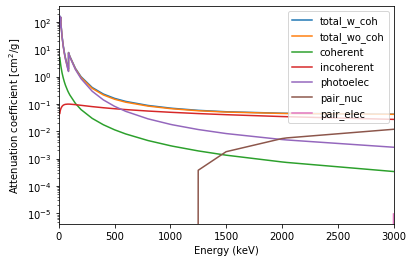

In [40]:
# query XCOM by element symbol
data = bq.xcom.fetch_xcom_data('Pb', e_range_kev=[10., 3000.])

plt.figure()
for field in ['total_w_coh', 'total_wo_coh', 'coherent', 'incoherent',
              'photoelec', 'pair_nuc', 'pair_elec']:
    plt.semilogy(data.energy, data[field], label=field)
plt.xlim(0, 3000)
plt.xlabel('Energy (keV)')
plt.ylabel(r'Attenuation coefficient [cm$^2$/g]')
plt.legend();